In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

import scipy

import seaborn as sns

import torch

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.parameter import Parameter as Parameter
from torch.autograd.functional import hessian

from torch.optim import SGD

from tqdm import tqdm

# Prepare the Data

In [2]:
df = pd.read_csv("../../data/cleaned_filtered_dataset_nans.csv")

In [3]:
winners = df["Winner"].tolist()
losers = df["Loser"].tolist()
teams = set(winners) | set(losers)

In [4]:
mapping = dict(zip(teams, range(len(teams))))

In [5]:
inv_mapping = dict(zip(range(len(teams)), teams))

In [6]:
winners_id = [mapping[x] for x in winners]
losers_id = [mapping[x] for x in losers]

In [7]:
winners_id = np.array(winners_id)
losers_id = np.array(losers_id)

# Bayes Model

In [8]:
with pm.Model() as model:
    player_skills = pm.Normal(
        "player_skills", 0.0, sigma=1.0, shape=(len(teams),)
    )

    logit_skills = player_skills[winners_id] - player_skills[losers_id]
    lik = pm.Bernoulli(
        "win_lik", logit_p=logit_skills, observed=np.ones(winners_id.shape[0])
    )

    idata = pm.sample(nuts_sampler="blackjax", chains=1, progressbar=True, draws=1000)

/home/cometku/miniconda3/envs/bayes/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Compiling...
2023-12-14 11:31:32.955732: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 11.6 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/cometku/miniconda3/envs/bayes/lib/python3.11/site-packages/pymc/sampling/jax.py:454: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(
Compilation time = 0:00:05.739533
Sampling...
Sampling time = 0:02:25.03

# Bayes Model Analysis

In [9]:
summary = az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [10]:
summary["ess_bulk"].mean()

1752.27802743614

In [11]:
summary["ess_bulk"].quantile(0.5)

1743.0

In [12]:
summary["ess_bulk"].quantile(0.025)

999.0

In [13]:
summary["ess_bulk"].quantile(0.975)

2535.0

In [14]:
az.rcParams["plot.max_subplots"] = 40

In [15]:
test = idata["posterior"]["player_skills"][0, :, [0,1,2,3]].to_numpy()

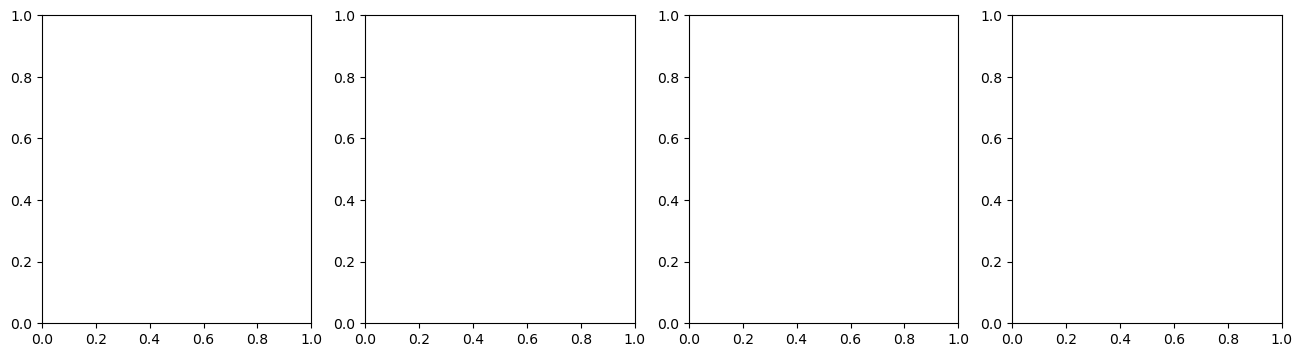

In [29]:
fig, axs = plt.subplots(1, 4, figsize=(16,4))

In [30]:
x_pdf = np.linspace(-5, 5, 100)
y_pdf = scipy.stats.norm.pdf(x_pdf)

In [31]:
posterior = sns.kdeplot(idata["posterior"]["player_skills"][0, :, 0], ax=axs[0], label="Posterior")
prior_1 = axs[0].plot(x_pdf, y_pdf, 'r', lw=2, label="Prior") 

axs[0].legend()

sns.kdeplot(idata["posterior"]["player_skills"][0, :, 1], ax=axs[2], label="Posterior")
axs[2].plot(x_pdf, y_pdf, 'r', lw=2, label="Prior") 

axs[2].legend()

axs[0].set_xlabel('Team Skill')
axs[0].set_ylabel('Density')
axs[0].set_title(f'Team {inv_mapping[0]} Skill')

axs[2].set_xlabel('Team Skill')
axs[2].set_ylabel('Density')
axs[2].set_title(f'Team {inv_mapping[1]} Skill')


Text(0.5, 1.0, 'Team Salem C Skill')

In [32]:
sns.lineplot(idata["posterior"]["player_skills"][0, :, 0], ax=axs[1])
sns.lineplot(idata["posterior"]["player_skills"][0, :, 1], ax=axs[3])

axs[1].set_ylabel('Team Skill')
axs[1].set_xlabel('Sample Number')
axs[1].set_title(f'Team {inv_mapping[0]} Skill Trace Plot')

axs[3].set_ylabel('Team Skill')
axs[3].set_xlabel('Sample Number')
axs[3].set_title(f'Team {inv_mapping[1]} Skill Trace Plot')

Text(0.5, 1.0, 'Team Salem C Skill Trace Plot')

In [33]:
fig.tight_layout()

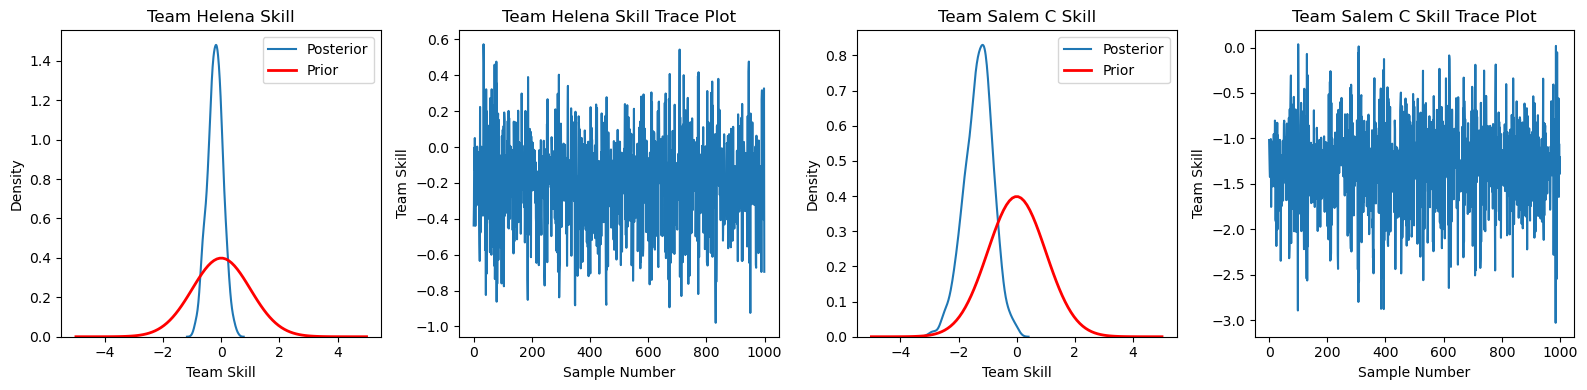

In [34]:
fig

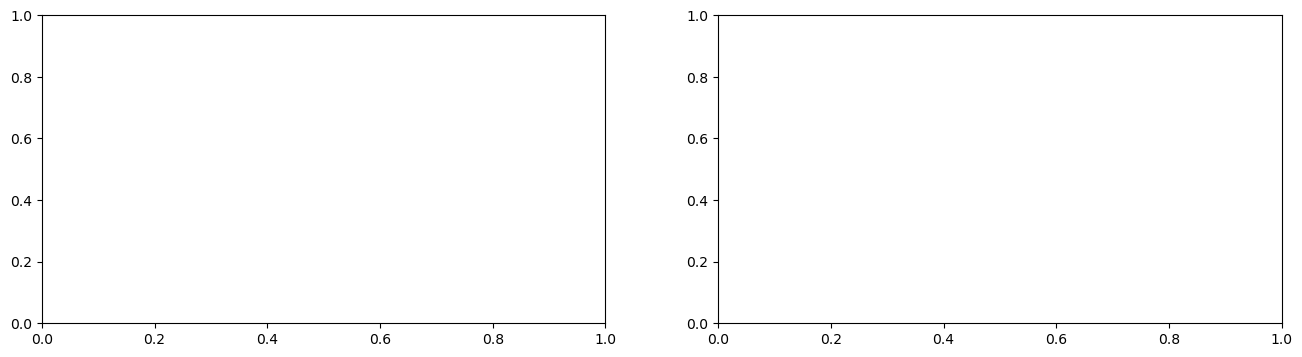

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

In [40]:
for i in range(2):
    auto_corr = az.autocorr(idata["posterior"]["player_skills"][0, :, i].to_numpy())
    sns.barplot(x=range(100), y=auto_corr[:100], ax=axs[i])

    axs[i].axhline(y = 1.96 / auto_corr.size**0.5,    # Line on y = 0.2
            xmin = 0, # From the left
            xmax = 100,
            color = "gray",
            linestyle = "--"
            )
    axs[i].axhline(y = -1.96 / auto_corr.size**0.5,    # Line on y = 0.2
            xmin = 0, # From the left
            xmax = 100,
            color = "gray",
            linestyle = "--"
            )

for i,ax in enumerate(axs):
    ax.set_xlabel('Lag')
    ax.set_ylabel('ACF')
    ax.set_title(f'Team {inv_mapping[i]} Sample ACF')

    ax.set_xticks([0, 20, 40, 60, 80, 100])

In [41]:
fig.tight_layout()

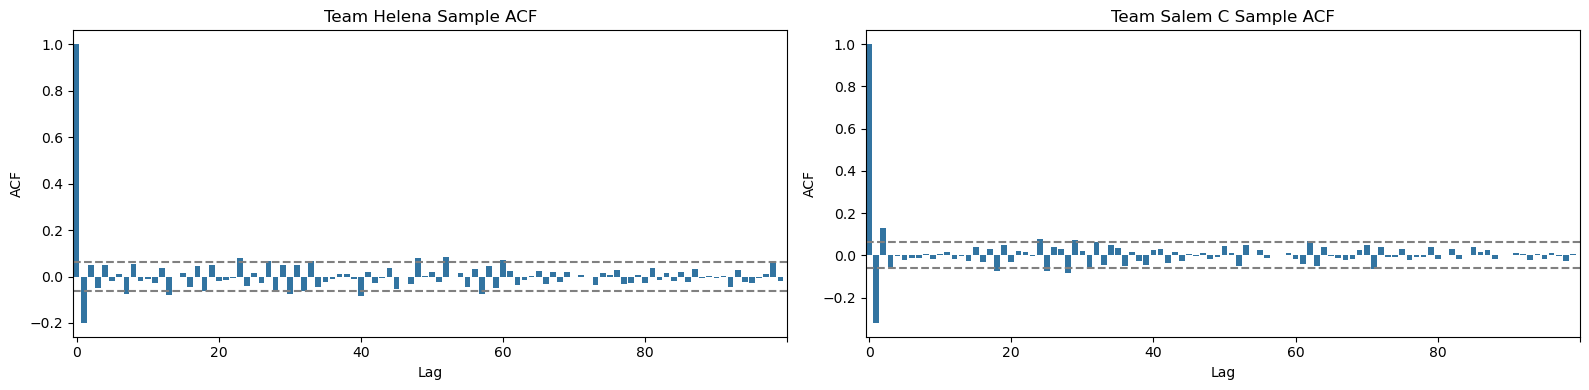

In [42]:
fig

In [192]:
total_autocorr = []
for i in range(len(teams)):
    auto_corr = az.autocorr(idata["posterior"]["player_skills"][0, :, i].to_numpy())

    total_autocorr.append(auto_corr)

In [43]:
player_skills = idata["posterior"]["player_skills"][0].to_numpy()

In [50]:
[inv_mapping[x] for x in sorted_indicies][-10:]

['IMSA A',
 'Middlesex A',
 'Ladue',
 'Richard Montgomery A',
 'Montgomery Blair A',
 'Ladue A',
 'Challenger-Almaden',
 'Beavercreek A',
 'Hunter A',
 'Detroit Catholic Central A']

In [51]:
average_player[-10:]

array([3.61286534, 3.65770865, 3.68380826, 3.70145341, 3.74672793,
       3.74768485, 3.77865682, 3.84006706, 4.07728835, 4.0947171 ])

In [52]:
lq[-10:]

array([3.2408546 , 3.2551051 , 3.20435978, 3.42834524, 3.30103402,
       3.17633411, 3.01341436, 3.22932002, 3.740818  , 3.83087199])

In [53]:
uq[-10:]

array([3.98599134, 4.10024092, 4.18961904, 4.01177029, 4.19956485,
       4.41218843, 4.54191787, 4.542311  , 4.40568218, 4.36557809])

Text(0.5, 0, 'Team ID')

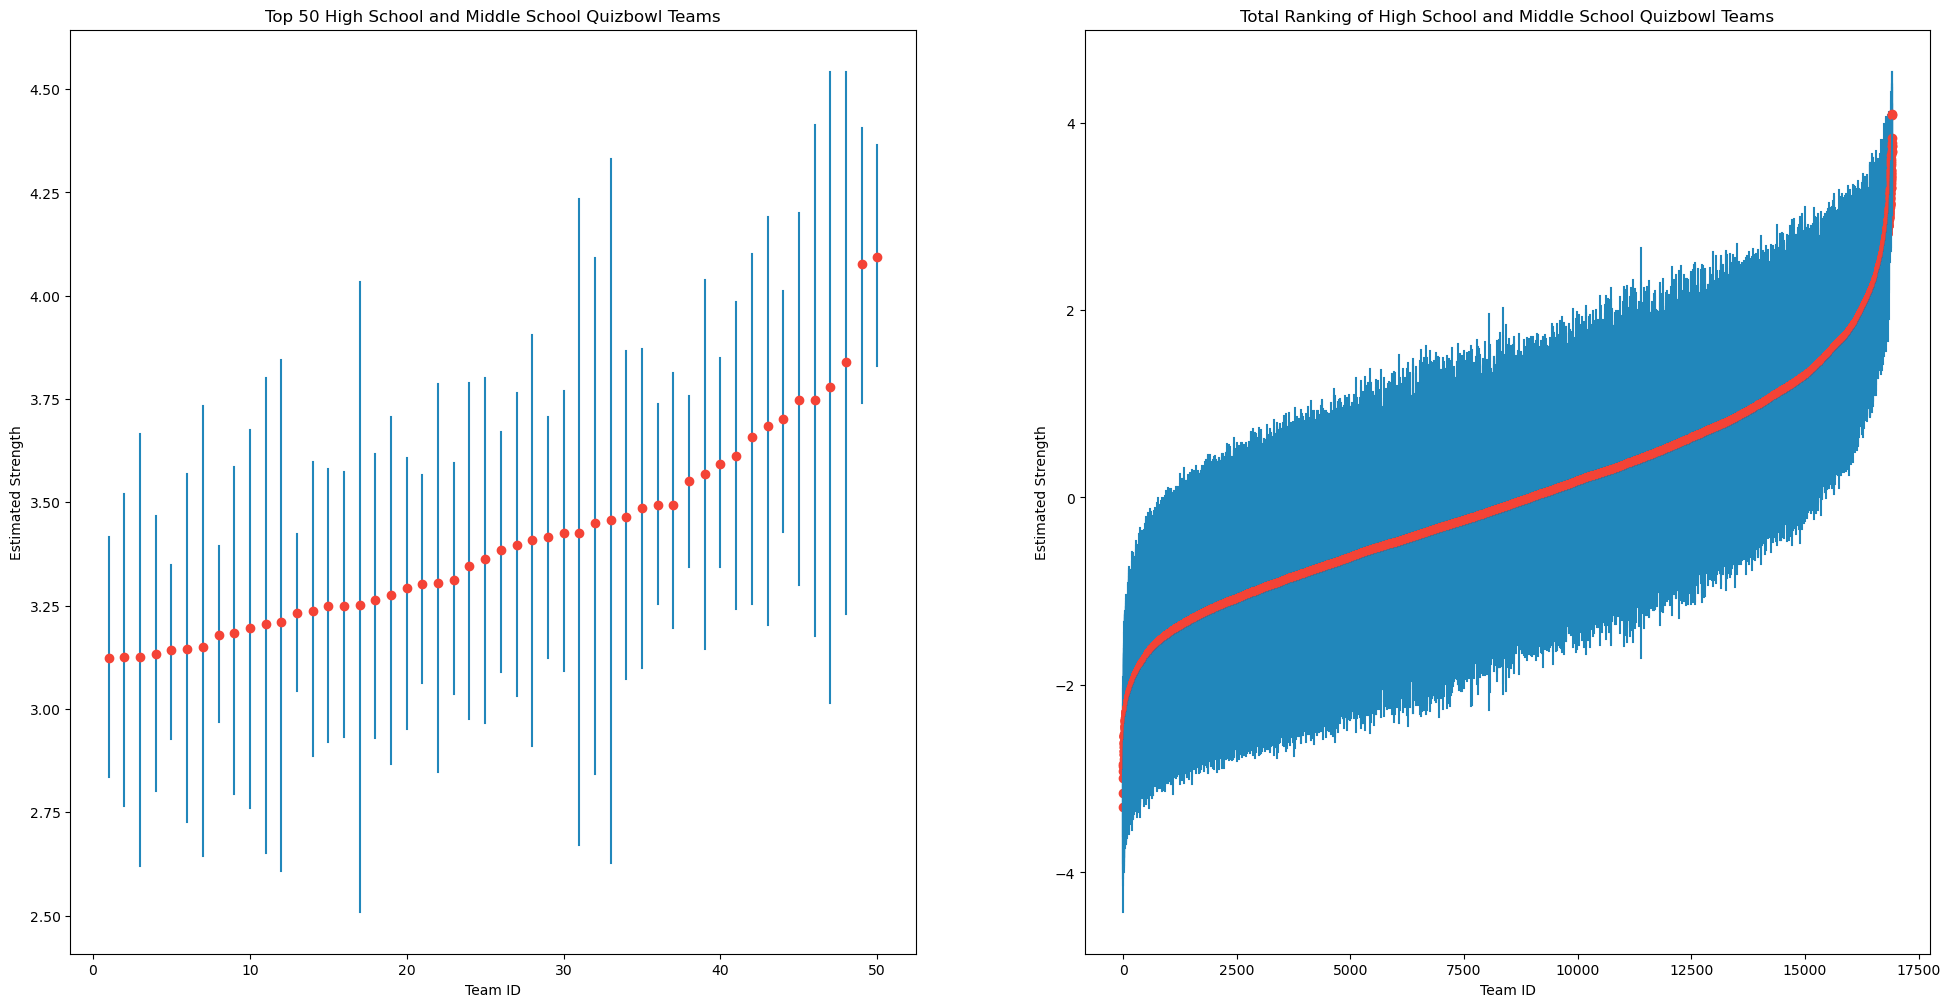

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(24, 12))

axs[0].set_title("Top 50 High School and Middle School Quizbowl Teams")

average_player = player_skills.mean(axis=0)

sorted_indicies = average_player.argsort()[-50:]

average_player = average_player[sorted_indicies]

lq = np.quantile(player_skills, 0.025, axis=0)[sorted_indicies]
uq = np.quantile(player_skills, 0.975, axis=0)[sorted_indicies]

for i in range(len(average_player)):
    mean = average_player[i]
    bottom = lq[i]
    top = uq[i]

    axs[0].plot([i + 1, i + 1], [top, bottom], color="#2187bb")

    axs[0].plot(i + 1, mean, "o", color="#f44336")

axs[0].set_ylabel("Estimated Strength")

axs[0].set_xlabel("Team ID")


axs[1].set_title("Total Ranking of High School and Middle School Quizbowl Teams")

average_player = player_skills.mean(axis=0)

sorted_indicies = average_player.argsort()

average_player = average_player[sorted_indicies]

# ax.set_xticks(
#     list(range(1, len(sorted_indicies) + 1)),
#     [inv_mapping[x] for x in sorted_indicies],
#     rotation=90,
# )

lq = np.quantile(player_skills, 0.025, axis=0)[sorted_indicies]
uq = np.quantile(player_skills, 0.975, axis=0)[sorted_indicies]

for i in range(len(average_player)):
    mean = average_player[i]
    bottom = lq[i]
    top = uq[i]

    axs[1].plot([i + 1, i + 1], [top, bottom], color="#2187bb")

    axs[1].plot(i + 1, mean, "o", color="#f44336")

axs[1].set_ylabel("Estimated Strength")

axs[1].set_xlabel("Team ID")

In [46]:
fig.tight_layout()

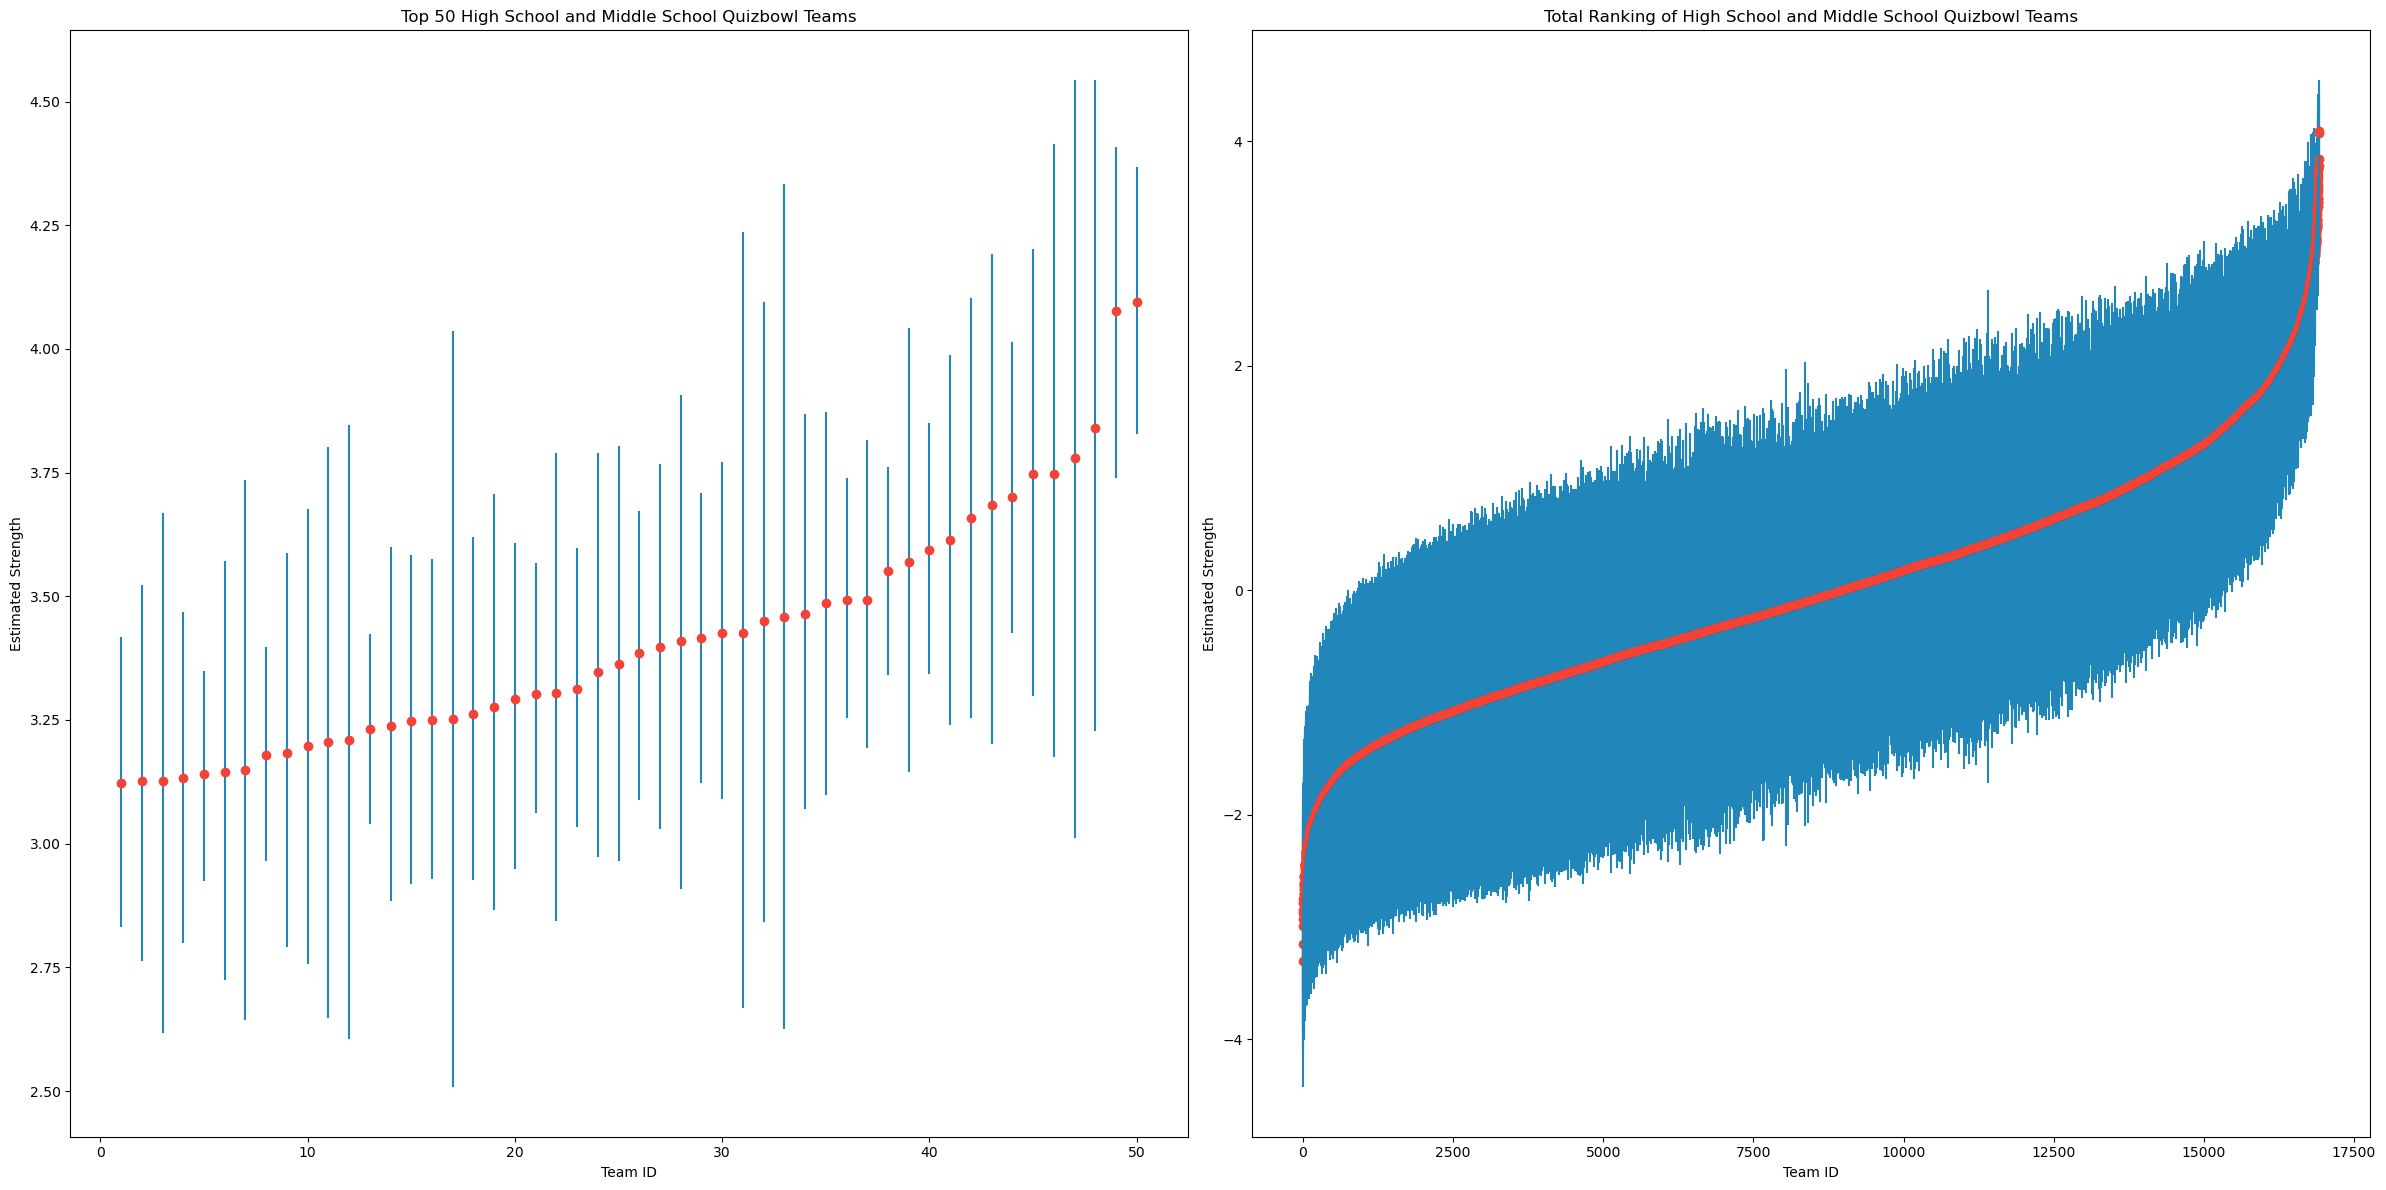

In [47]:
fig

# MLE Model

In [13]:
import torch

from torch import nn
from torch.nn.parameter import Parameter as Parameter
from torch.autograd.functional import hessian

from torch.optim import SGD

from tqdm import tqdm

import pymc as pm

import numpy as np

import pandas as pd

import math

class BradleyTerry(nn.Module):
    def __init__(self, win_data):
        super().__init__()
        self.win_data = win_data.t()
        self.weights = Parameter(torch.ones(self.win_data.shape[1]))
        self.logsigmoid = torch.nn.LogSigmoid()

    def log_prob(self, weights):
        log_prob = (self.win_data * self.logsigmoid(weights.unsqueeze(0) - weights.unsqueeze(1))).sum()

        return log_prob

    def estimate_parameters(self, epochs, lr=1e-8):
        optimizer = SGD(self.parameters(), lr=lr)

        for i in tqdm(range(epochs)):
            log_likelihood = self.log_prob(self.weights)

            (-log_likelihood).backward()

            optimizer.step()

            if i % 100 == 0 and i!= 0:
                print(i, torch.abs(log_likelihood))

            with torch.no_grad():
                self.weights -= (self.weights.sum() / len(self.weights))

In [ ]:
win_data = torch.zeros((len(teams), len(teams)))
for winner, loser in zip(winners_id, losers_id):
    win_data[winner][loser] +=1

In [ ]:
bt = BradleyTerry(win_data.to("cuda"))
bt.to("cuda")
bt.estimate_parameters(4300)

In [ ]:
MLE = bt.weights.cpu().detach().numpy()

In [16]:
with open("../../test2.csv", "r") as f:
    MLE = np.array([float(x.strip()) for x in f.readlines()])

In [18]:
with open("../../teams.csv", "r") as f:
    inv_mapping = dict(zip(range(len(teams)), [x.strip() for x in f.readlines()]))

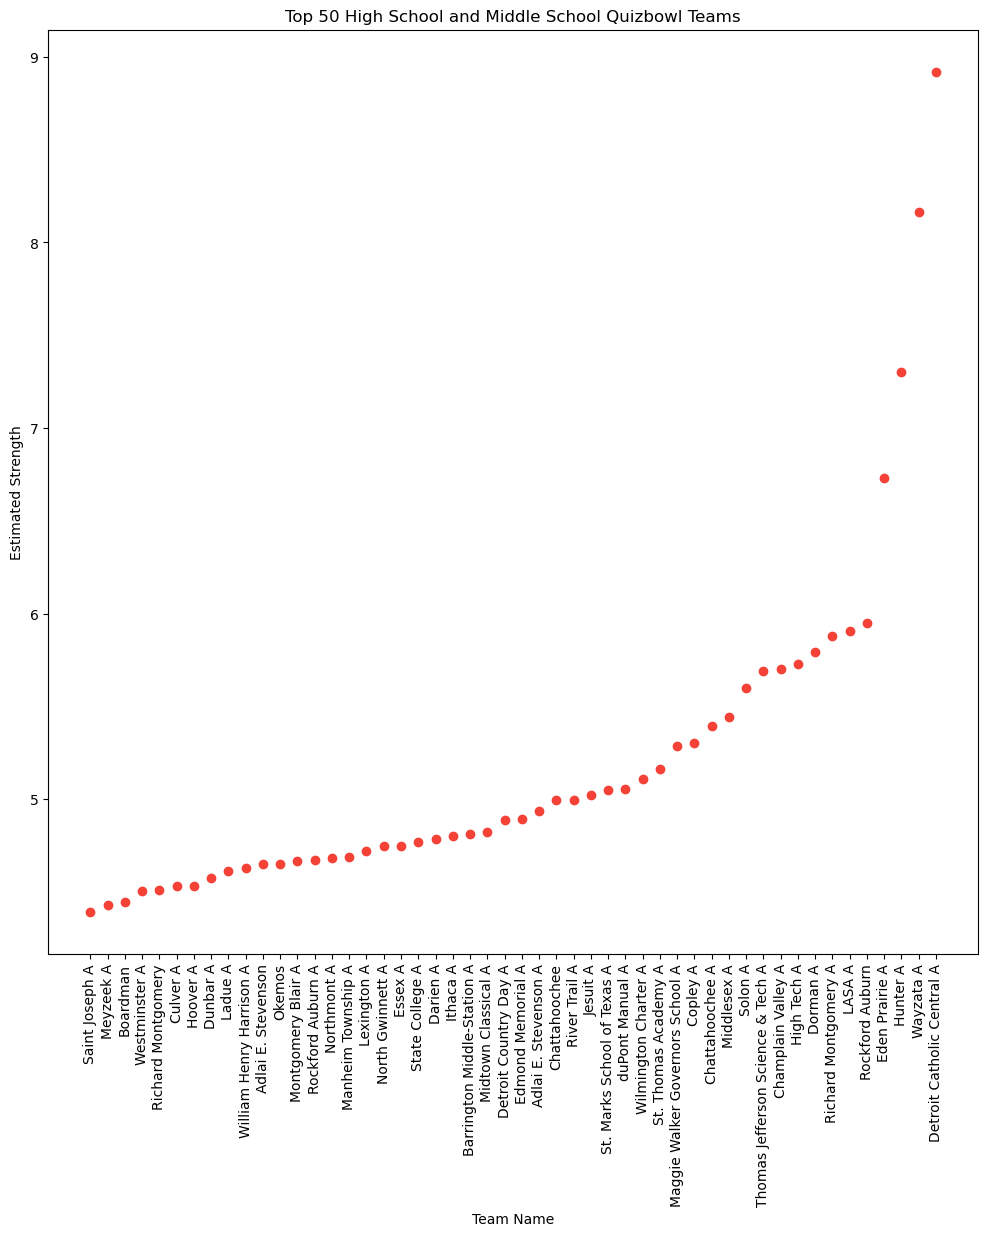

In [23]:
sorted_indicies_MLE = MLE.argsort()[-50:]

average_player_MLE = MLE[sorted_indicies_MLE]
fig, ax = plt.subplots(figsize=(12, 12))

ax.set_title("Top 50 High School and Middle School Quizbowl Teams")

ax.set_ylabel("Estimated Strength")

ax.set_xlabel("Team Name")

ax.set_xticks(
    list(range(1, len(sorted_indicies_MLE) + 1)),
    [inv_mapping[x] for x in sorted_indicies_MLE],
    rotation=90,
)

for i in range(len(average_player_MLE)):
    mean = average_player_MLE[i]

    ax.plot(i + 1, mean, "o", color="#f44336")

plt.show()


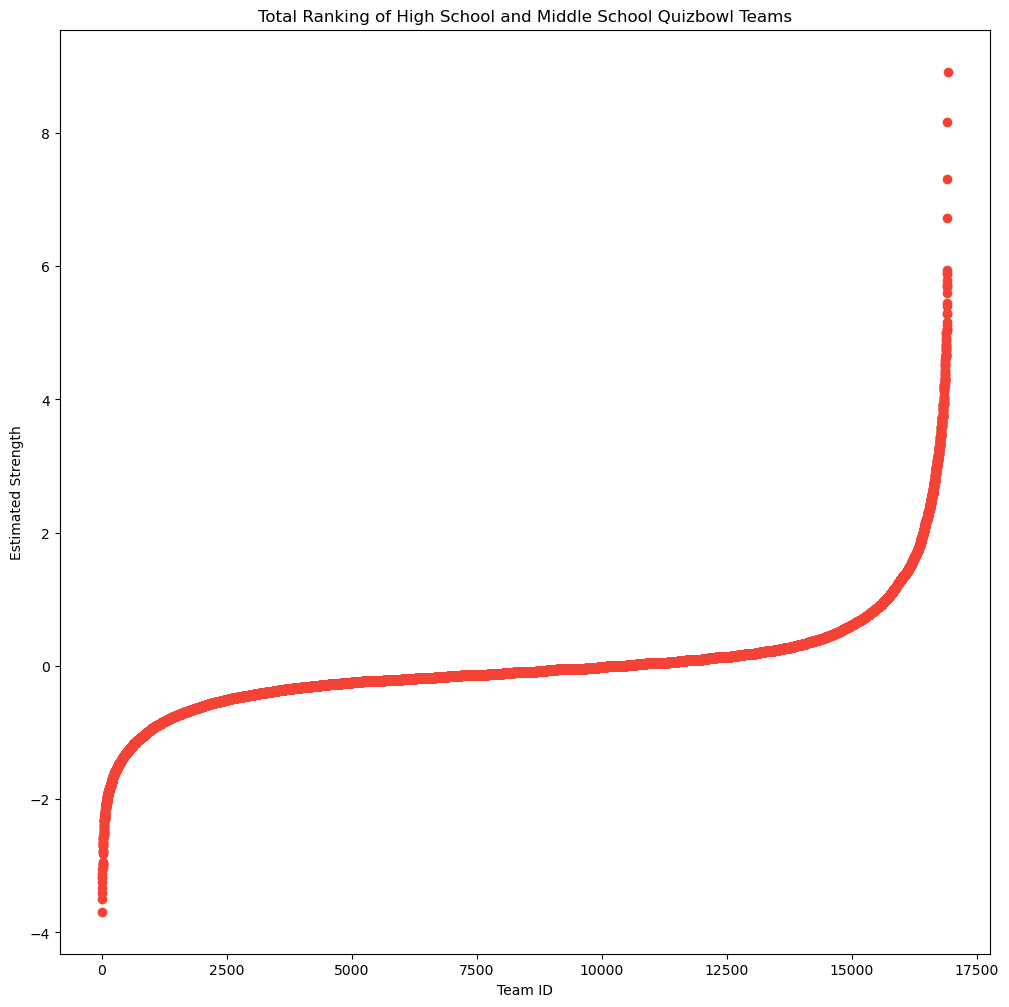

In [22]:
sorted_indicies_MLE = MLE.argsort()

average_player_MLE = MLE[sorted_indicies_MLE]
fig, ax = plt.subplots(figsize=(12, 12))

ax.set_title("Total Ranking of High School and Middle School Quizbowl Teams")

ax.set_ylabel("Estimated Strength")

ax.set_xlabel("Team ID")

# ax.set_xticks(
#     list(range(1, len(sorted_indicies_MLE) + 1)),
#     [inv_mapping[x] for x in sorted_indicies_MLE],
#     rotation=90,
# )

for i in range(len(average_player_MLE)):
    mean = average_player_MLE[i]

    ax.plot(i + 1, mean, "o", color="#f44336")

plt.show()


In [ ]:
top50_teams = [inv_mapping[x] for x in sorted_indicies_MLE]

In [ ]:
df_filtered = df[df["Winner"].isin(top50_teams) | df["Loser"].isin(top50_teams)]

In [ ]:
winners = df_filtered["Winner"].tolist()
losers = df_filtered["Loser"].tolist()

teams = set(winners) | set(losers)

In [ ]:
mapping = dict(zip(teams, range(len(teams))))
inv_mapping = dict(zip(range(len(teams)), teams))

In [ ]:
winners_id = [mapping[x] for x in winners]
losers_id = [mapping[x] for x in losers]
winners_id = np.array(winners_id)
losers_id = np.array(losers_id)

In [ ]:
win_data = torch.zeros((len(teams), len(teams)))
for winner, loser in zip(winners_id, losers_id):
    win_data[winner][loser] +=1

bt = BradleyTerry(win_data.to("cuda"))
bt.to("cuda")
bt.estimate_parameters(1800)

fisher_information = hessian(bt.log_prob, bt.weights)

fisher_information = -fisher_information

variances = torch.inverse(fisher_information)

In [ ]:
MLE = bt.weights.cpu().detach().numpy()

fig, ax = plt.subplots(figsize=(12, 12))

ax.set_title("Top 50 High School and Middle School Quizbowl Teams")

sorted_indicies = MLE.argsort()[-50:]

average_player = MLE[sorted_indicies]

ax.set_xticks(
    list(range(1, len(sorted_indicies) + 1)),
    [inv_mapping[x] for x in sorted_indicies],
    rotation=90,
)

for i in range(len(average_player)):
    team = sorted_indicies[i]
    mean = average_player[i]
    ci = 1.96/(math.sqrt(variances[team][team]))
    bottom = mean -ci
    top = mean + ci

    ax.plot([i + 1, i + 1], [top, bottom], color="#2187bb")

    ax.plot(i + 1, mean, "o", color="#f44336")

ax.set_ylabel("Estimated Strength")

ax.set_xlabel("Team Name")


plt.show()